In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor
from IPython.display import clear_output
import traceback

from module.iris_preprocessing import load_CASIA, load_UBIPr, load_UBIPr_peri, save_iris_norm
from module.segment_anything.seg_any import find_iris, get_outline, get_inter, load_predictor, normalization

d:\Users\jimyj\Desktop\TAIST\Thesis\Source_Code\main\module\iris_preprocessing.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.2])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

In [3]:
predictor = load_predictor('vit_l')

In [4]:
img_path = 'D:/Users/jimyj/Desktop/TAIST/Thesis/Source_Code/main/Iris-Dataset/CASIA-Iris-Thousand/043/L/S5043L05.jpg' 

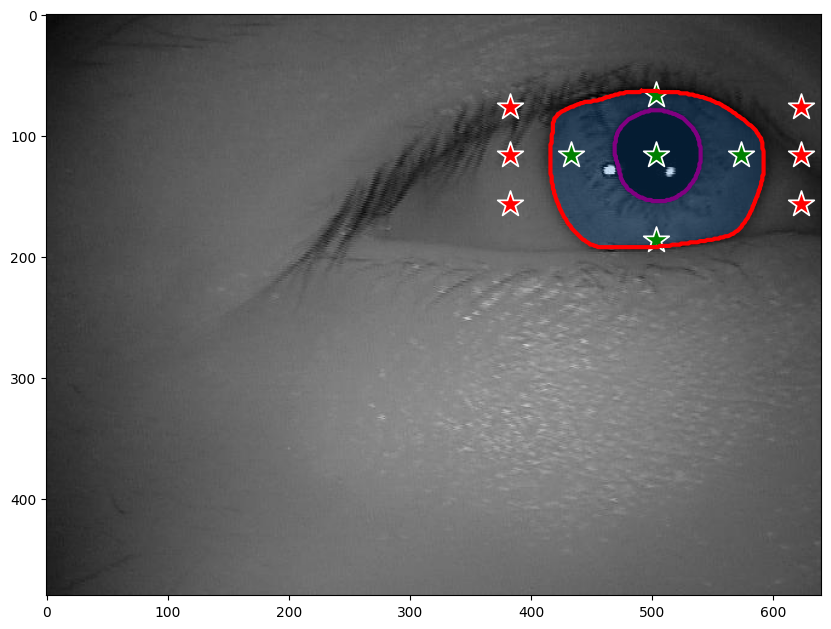

In [5]:
masks_pupil, masks_iris, input_point, input_label = find_iris(predictor, img_path)

outline_pupil = get_inter(get_outline(masks_pupil[0]))
outline_iris = get_inter(get_outline(masks_iris[0]))

plt.figure(figsize=(10, 10))
plt.imshow(cv2.imread(img_path))
show_mask(masks_iris, plt.gca())
show_points(input_point, input_label, plt.gca())

plt.plot(outline_pupil[:, 0], outline_pupil[:, 1], 'purple', linewidth=3)
plt.plot(outline_iris[:, 0], outline_iris[:, 1], 'r', linewidth=3)
plt.show()

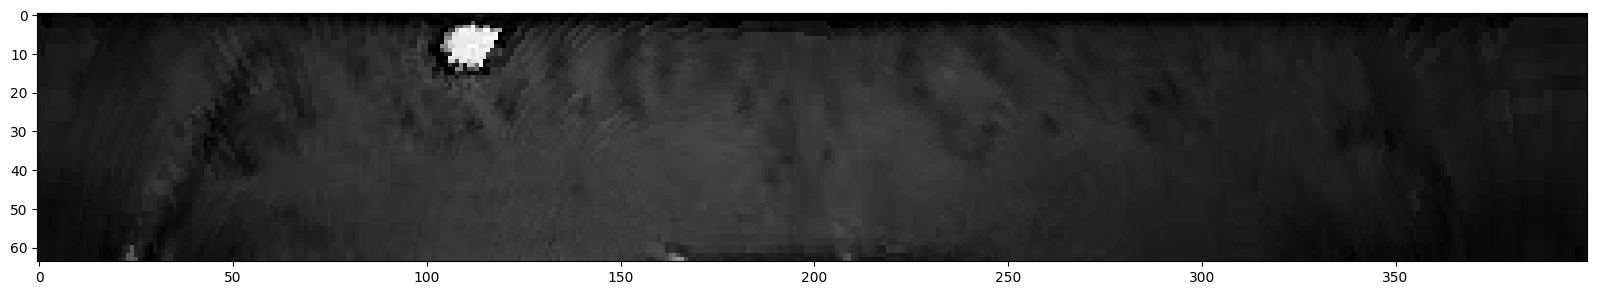

In [6]:
plt.figure(figsize=(20, 10))
plt.imshow(normalization(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), outline_pupil, outline_iris, M=64, N=400), cmap='gray')

In [4]:
img_p_cl = 15
_, iris_label = load_CASIA('Iris-Dataset/CASIA-Iris-Lamp', img_p_cl)

In [5]:
img_p_cl = 15
_, iris_label = load_UBIPr('Iris-Dataset/UBIPr', img_p_cl)

  0%|          | 0/7080 [00:00<?, ?it/s]

In [10]:
import pandas as pd
from tqdm.autonotebook import tqdm

In [20]:
def iris_norm(data_df, test_beg, test_til, chunk=None):
    data_df = pd.DataFrame(data_df.T, columns=["dir1", "img_num", "img_path"])

    iris_norm_L = []
    iris_norm_R = []
    files_name = []
    
    data_df = data_df.loc[
        data_df.dir1.str[:-1].astype(int).between(test_beg, test_til - 1)
    ]

    for i in tqdm(range(len(data_df)), total=len(data_df), desc=f"Normalizing Iris {chunk} Chunk"):
        dir1 = data_df.dir1.values[i]
        img_num = data_df.img_num.values[i]
        img_path = data_df.img_path.values[i]
        img_og = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        try:
            masks_pupil, masks_iris, _, _ = find_iris(predictor, img_path)
            if masks_pupil is not None and masks_iris is not None:
                outline_pupil = get_inter(get_outline(masks_pupil[0]))
                outline_iris = get_inter(get_outline(masks_iris[0]))
                
                if outline_pupil is None or outline_iris is None:
                    iris_norm = np.zeros((16, 400))
                else:
                    iris_norm = normalization(img_og, outline_pupil, outline_iris, M=16, N=400)
            else:
                iris_norm = np.zeros((16, 400))
        except Exception as e:
            print(f'File {img_path} failed:')
            traceback.print_exc()
            return None
        
        iris_norm_L.append(iris_norm) if dir1[-1] == "0" else iris_norm_R.append(iris_norm)
        files_name.append(f"{dir1[:-1]}/{img_num}.jpg") if dir1[-1] == "0" else None
        
    df = pd.DataFrame(
        {
            "files_name": files_name,
            "iris_norm_L": iris_norm_L,
            "iris_norm_R": iris_norm_R,
        }
    )

    return df

In [21]:
def norm_chunk(total_len, chunk_size, start_chunk=0):
    cur_chunk = 0
    while cur_chunk < total_len:
        iris_norm_seg_any = iris_norm(iris_label, cur_chunk, cur_chunk+chunk_size, cur_chunk//chunk_size)
        if iris_norm_seg_any is None:
            break
        save_iris_norm("temp_data/iris_norms/irisNorm_segAny_ubipr.npz", iris_norm_seg_any)
        clear_output()
        cur_chunk += chunk_size

In [22]:
norm_chunk(260, 10, 0)

In [23]:
with np.load('temp_data/iris_norms/irisNorm_segAny_ubipr.npz') as data:
    iris_norm_L = data['iris_norm_L']
    iris_norm_R = data['iris_norm_R']

In [100]:
# iris_norm_seg_any = iris_norm(iris_label, 411, 412, 411)

Normalizing Iris 411 Chunk:   0%|          | 0/30 [00:00<?, ?it/s]

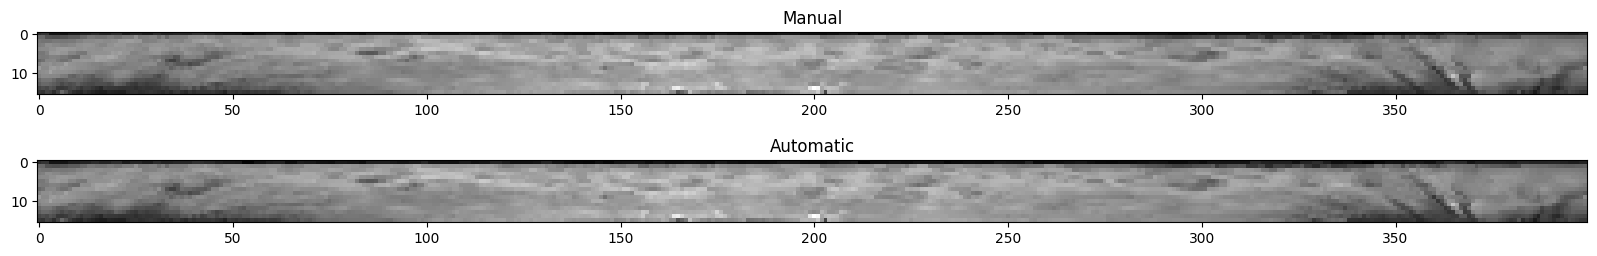

In [130]:
img_path = 'D:/Users/jimyj/Desktop/TAIST/Thesis/Source_Code/main/Iris-Dataset/CASIA-Iris-Lamp/396/R/S2396R15.jpg' 
masks_pupil, masks_iris, input_point, input_label = find_iris(predictor, img_path)

outline_pupil = get_inter(get_outline(masks_pupil[0]))
outline_iris = get_inter(get_outline(masks_iris[0]))


fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].imshow(normalization(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), outline_pupil, outline_iris, M=16, N=400), cmap='gray')
axes[0].set_title('Manual')
axes[1].imshow(iris_norm_R[5729], cmap="gray")
axes[1].set_title('Automatic')
plt.subplots_adjust(wspace=0.1, hspace=-0.8)

In [77]:
uniques, counts = np.unique(iris_norm_R, axis=0, return_counts=True)

In [78]:
np.unique(counts)

array([ 1, 95], dtype=int64)

In [79]:
np.where(counts == 2)[0]

array([], dtype=int64)

In [80]:
for test in np.where(counts == 2)[0]:
    print(np.where((iris_norm_L.reshape(iris_norm_L.shape[0], -1) == uniques[test].reshape(-1)).all(axis=1)))